In [80]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from unc.utils import load_info
from unc.agents import Agent, DQNAgent
from definitions import ROOT_DIR

In [5]:
results_fname = Path(ROOT_DIR, "results", "lobster_data.npy")
loaded = load_info(results_fname)

In [7]:
obs_res = loaded['2']
unc_res = loaded['2o']

In [188]:
# reduced_unc_obses = get_distilled_obs(unc_res['obs'][0])
unc_obs = unc_res['obs']
at_zero_unc = unc_obs[:, :, 0] == 1

r1_ot_unc = unc_obs[:, :, 3]
r2_ot_unc = unc_obs[:, :, 6]
print(f"r1_ot min: {r1_ot_unc[at_zero_unc].min()}, r1_ot max: {r1_ot_unc[at_zero_unc].max()}")
print(f"r2_ot min: {r2_ot_unc[at_zero_unc].min()}, r2_ot max: {r2_ot_unc[at_zero_unc].max()}")

obs_obs = obs_res['obs']
at_zero_obs = obs_obs[:, :, 0] == 1

r1_ot_obs = obs_obs[:, :, 3]
r2_ot_obs = obs_obs[:, :, 6]
print(f"r1_ot_unc min: {r1_ot_obs[at_zero_obs].min()}, r1_ot_unc max: {r1_ot_obs[at_zero_obs].max()}")
print(f"r2_ot_unc min: {r2_ot_obs[at_zero_obs].min()}, r2_ot_unc max: {r2_ot_obs[at_zero_obs].max()}")

r1_ot min: 0.0, r1_ot max: 0.9
r2_ot min: 0.0, r2_ot max: 0.9
r1_ot_unc min: 0.0, r1_ot_unc max: 0.0
r2_ot_unc min: 0.0, r2_ot_unc max: 0.0


In [189]:


def get_distilled_obs(traj):
    # first we get position
    pos_one_hot = traj[:, :3]
    pos_traj = np.nonzero(pos_one_hot)[-1]
    ot1 = traj[:, 3]
    ot2 = traj[:, 6]
    reduced_obses = np.stack([pos_traj, ot1, ot2], axis=-1)
    return reduced_obses

In [190]:
# reduced_unc_obses = get_distilled_obs(unc_res['obs'][0])
traj_obs = obs_res['obs'][0]

reduced_obs_obs = get_distilled_obs(traj_obs)


Text(0.5, 0.92, 'Q-values of Lobster environment at node 0 (uncertainty obs)')

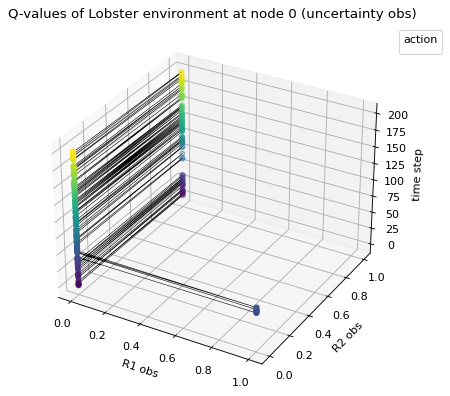

In [201]:

fig = plt.figure(figsize=(8, 6), dpi=80)
colors = (z/x.shape[0])[None, :]


ax = fig.add_subplot(projection='3d')
for i in range(1):
    x = r1_ot_obs[i]
    y = r2_ot_obs[i]
    z = np.arange(x.shape[0])
#     x = reduced_obs_obs[:, 1]
#     y = reduced_obs_obs[:, 2]
#     z = reduced_obs_obs[:, 0]

    ax.scatter(x, y, z, c=z, cmap='viridis')
    ax.plot3D(x, y, z, color="black", linewidth=0.5)


ax.set_xlabel("R1 obs")
ax.set_ylabel("R2 obs")
ax.set_zlabel(f"time step")

plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left', title='action')
ax.set_title("Q-values of Lobster environment at node 0 (uncertainty obs)")

In [192]:
traj_unc = unc_res['obs'][0]

reduced_obs_unc = get_distilled_obs(traj_unc)

Text(0.5, 0.92, 'Q-values of Lobster environment at node 0 (uncertainty obs)')

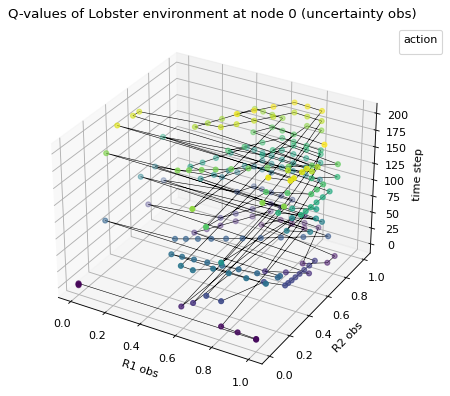

In [200]:

fig = plt.figure(figsize=(8, 6), dpi=80)
colors = (z/x.shape[0])[None, :]


ax = fig.add_subplot(projection='3d')
for i in range(1):
    x = r1_ot_unc[i]
    y = r2_ot_unc[i]
    z = np.arange(x.shape[0])
#     x = reduced_obs_unc[:, 1]
#     y = reduced_obs_unc[:, 2]
#     z = reduced_obs_unc[:, 0]

    ax.scatter(x, y, z, c=z, cmap='viridis')
    ax.plot3D(x, y, z, color="black", linewidth=0.5)


ax.set_xlabel("R1 obs")
ax.set_ylabel("R2 obs")
ax.set_zlabel(f"time step")

plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left', title='action')
ax.set_title("Q-values of Lobster environment at node 0 (uncertainty obs)")

r1_ot min: 0.0, r1_ot max: 0.9
r2_ot min: 0.0, r2_ot max: 0.9


In [84]:

# here we get all possible observations at node 0 for 2
zero_obs_2 = np.array([[1., 0., 0., 0., 0., 1., 0., 0., 1.]])

# all possible observations at node 0 for 2o
discount = 0.9

obs_2o_range_single = discount ** (np.arange(50) + 1)
obs_2o_range_x, obs_2o_range_y = np.meshgrid(obs_2o_range_single, obs_2o_range_single)
obs_2o_range = np.stack((obs_2o_range_x, obs_2o_range_y), axis=-1)
ot_obs_2o = obs_2o_range.reshape(-1, 2)

zero_obs_2o = np.repeat(zero_obs_2, ot_obs_2o.shape[0], axis=0)
zero_obs_2o[:, [3, 6]] = ot_obs_2o

In [132]:
fa = 'linear'
obs_agent_fname = Path(ROOT_DIR, 'results', f'2_{fa}_agent.pth')
unc_agent_fname = Path(ROOT_DIR, 'results', f'2o_{fa}_agent.pth')

obs_agent = DQNAgent.load(obs_agent_fname, DQNAgent)
unc_agent = DQNAgent.load(unc_agent_fname, DQNAgent)

In [133]:
all_zero_2_qs = obs_agent.Qs(zero_obs_2, obs_agent.network_params)
all_zero_2o_qs = unc_agent.Qs(zero_obs_2o, unc_agent.network_params)

Text(0.5, 0.92, 'Q-values of Lobster environment at node 0 (uncertainty obs)')

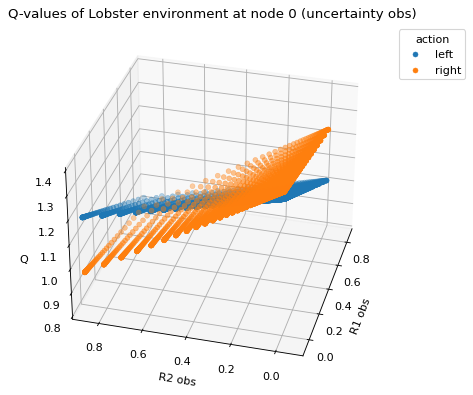

In [165]:
actions_to_plot = [0, 1]
action_mapping = ['left', 'right', 'collect']
actions_to_color = ["orange", "blue"]

fig = plt.figure(figsize=(8, 6), dpi=80)

ax = fig.add_subplot(projection='3d')
ax.view_init(32, 195)

ax.set_xlim(-0.1, 0.9)
ax.set_ylim(-0.1, 0.9)
ax.set_zlim(0.8, 1.4)

ax.set_xlabel("R1 obs")
ax.set_ylabel("R2 obs")
ax.set_zlabel(f"Q")

for action in actions_to_plot:
    z = all_zero_2o_qs[:, action]
    ax.scatter(ot_obs_2o[:, 0], ot_obs_2o[:, 1], z, cmap='viridis', linewidth=0.5, label=action_mapping[action])

plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left', title='action')
ax.set_title("Q-values of Lobster environment at node 0 (uncertainty obs)")

Text(0.5, 0.92, 'Q-values of Lobster environment at node 0 (normal obs)')

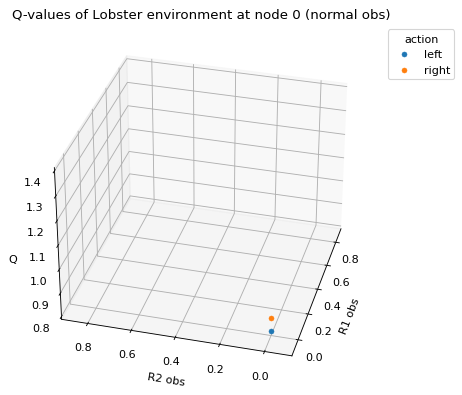

In [166]:
actions_to_plot = [0, 1]
action_mapping = ['left', 'right', 'collect']
actions_to_color = ["orange", "blue"]

fig = plt.figure(figsize=(8, 6), dpi=80)

ax = fig.add_subplot(projection='3d')
ax.view_init(32, 195)

ax.set_xlim(-0.1, 0.9)
ax.set_ylim(-0.1, 0.9)
ax.set_zlim(0.8, 1.4)


ax.set_xlabel("R1 obs")
ax.set_ylabel("R2 obs")
ax.set_zlabel(f"Q")

for action in actions_to_plot:
    z = all_zero_2_qs[:, action]
    ax.scatter(0, 0, z, cmap='viridis', linewidth=0.5, label=action_mapping[action])
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left', title='action')
ax.set_title("Q-values of Lobster environment at node 0 (normal obs)")